# Planning in Python

Here we illustrate how to use our library to pose the classical 'Elevetors' problem and solve it with our planning framework. We have implemented both blind search algorithms and informed (heuristic) search. This notebook gives a flavour of these techniques.


We start importing the relevant modules:

In [1]:
import planning

from IPython.display import display

#import random 

#random.seed(42)

Now let us pose a simple problem with 4 pegs and 5 disks. The domain is already defined and it contains a single operator: `move(?what-disk, ?from-object, ?to-object)`, which moves disk `?what` from object `?from` (either a peg or another disk) to object `?to` (also, either a peg or a disk). Our planning framework can take care of static preconditions. That is, it does not instantiate the move operator for moving a disk onto a smaller disk) so it is not necessary to encode static predicates in the state (the `smaller(?disk1,?disk2)` predicates that are typically seen in PDDL Hanoi domains).

We have also implemented a problem generator. The generator can create problems for any number of disks and pegs. It also allows random initial and ending configurations. Our first example will be fairly simple and will have 3 pegs, all the disks in the first peg in the initial state and all the disks in the third peg in the goal configuration. Although the goal in this case details the position of every disk, notice that this does not necessarily has to be the case always. The goal does not need to be a complete description of the end configuration. It is perfectly reasonable, and our framework allows it, to consider partial states (e.g. we want the biggest disk in the third peg, and we do not care about the rest).

Domain: Elevator
Types: {'passenger': 'object', 'floor': 'object'}
Operators:
  - board(?f-floor,?p-passenger):
    Pre: lift-at(?f), origin(?p,?f)
    Add: boarded(?p)
    Delete: 
  - depart(?f-floor,?p-passenger):
    Pre: lift-at(?f), destin(?p,?f), boarded(?p)
    Add: served(?p)
    Delete: boarded(?p)
  - drive_down(?f1-floor,?f2-floor):
    Pre: lift-at(?f1), above(?f2,?f1)
    Add: lift-at(?f2)
    Delete: lift-at(?f1)
  - drive_up(?f1-floor,?f2-floor):
    Pre: lift-at(?f1), above(?f1,?f2)
    Add: lift-at(?f2)
    Delete: lift-at(?f1)
Problem: elevator-00
Domain: Elevator
Initial state:
  above(floor1,floor2)
  above(floor2,floor3)
  above(floor3,floor4)
  destin(passenger01,floor1)
  destin(passenger02,floor3)
  destin(passenger03,floor2)
  lift-at(floor1)
  origin(passenger01,floor1)
  origin(passenger02,floor4)
  origin(passenger03,floor3)
Goal:
  served(passenger01)
  served(passenger02)
  served(passenger03)
Ground operators:
  board(floor1,passenger01)
  board(floor1,p

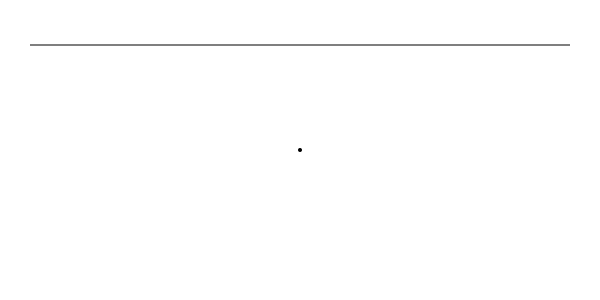

Goal:


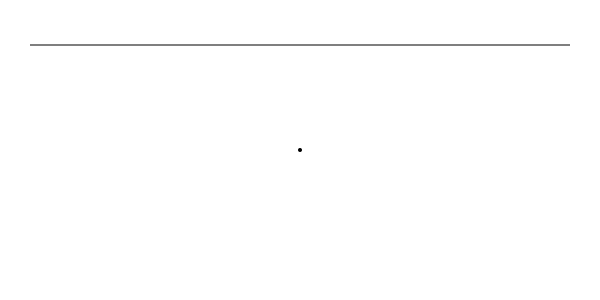

Applicable actions in 1st state:
board(floor1,passenger01)
drive_up(floor1,floor2)


In [2]:
domain = planning.domains["Elevator"]
problem = domain.generate_problem(3, 4)
print(domain)
print(problem)
print("Init:")
display(problem.init())
print("Goal:")
display(problem.goal())
print("Applicable actions in 1st state:")
print("\n".join(map(str, filter(problem.init().can_apply, problem.operators()))))

Let us start applying blind search algorithms. Namely, we have implemented Breadth First Search (BFS) and Iterative Deepening Search (IDS). The algorithms have an exponential worst time complexity. More specifically, both have a time complexity of $ O(b^d) $ where $ b $ is the branching factor and $ d $ is the length of the plan. Moreover, BFS is very memory intensive, requiring also an exponential amount of memory. IDS sacrifices speed for memory efficiency: it has a linear memory usage, but requires more time than BFS to find a plan, namely, a constant factor times the time required by BFS which, of course, is hidden in the big O notation.

Let us start with BFS:

[0.013s] Plan found with 9 action(s)
#Generated nodes: 125
Plan:
  board(floor1,passenger01)
  board(floor1,passenger03)
  drive_up(floor1,floor2)
  depart(floor2,passenger01)
  depart(floor2,passenger03)
  drive_up(floor2,floor3)
  board(floor3,passenger02)
  drive_down(floor3,floor2)
  depart(floor2,passenger02)
step 0


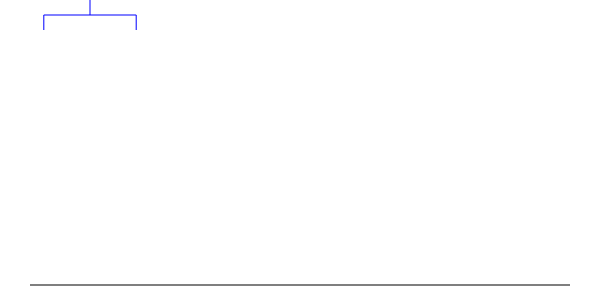

step 1


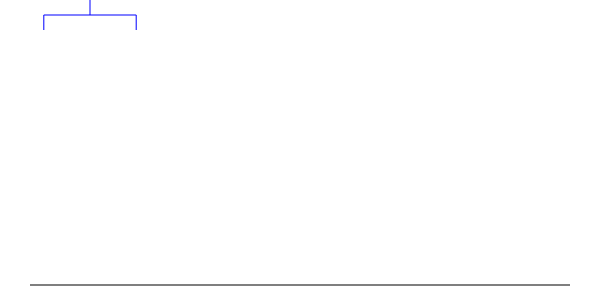

step 2


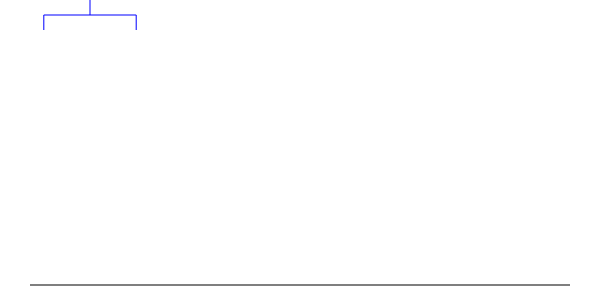

step 3


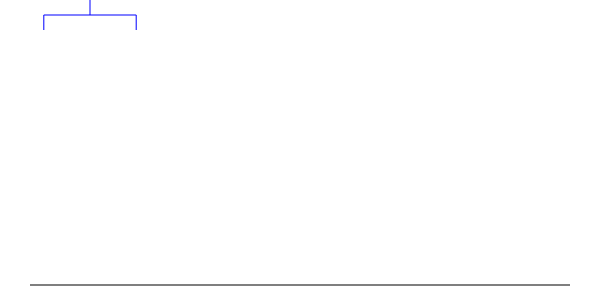

step 4


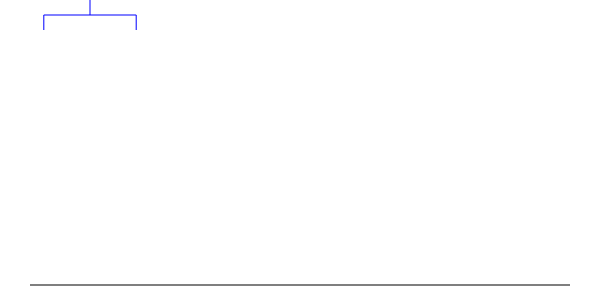

step 5


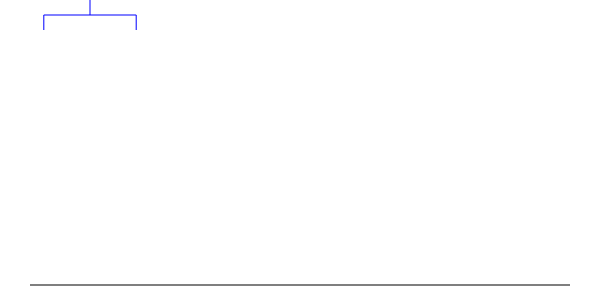

step 6


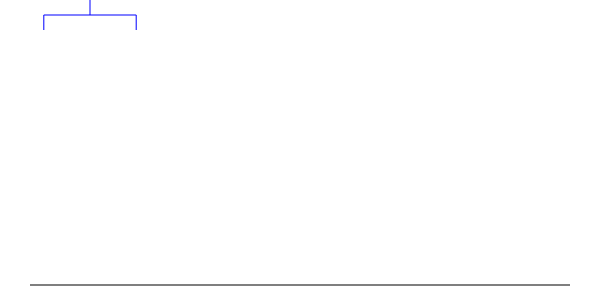

step 7


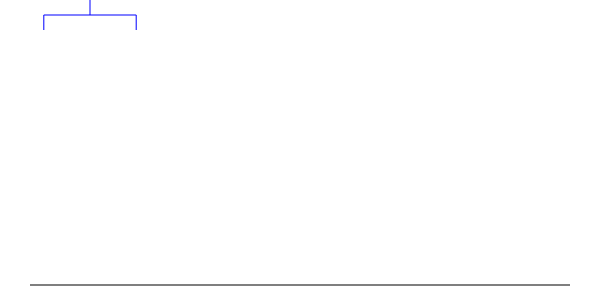

step 8


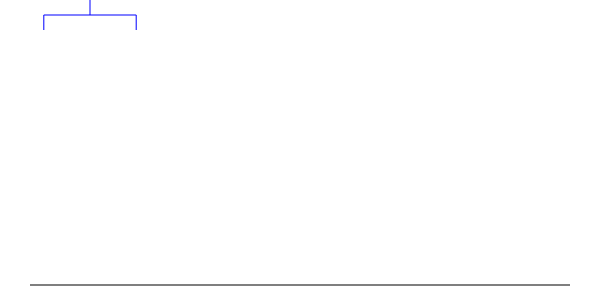

step 9


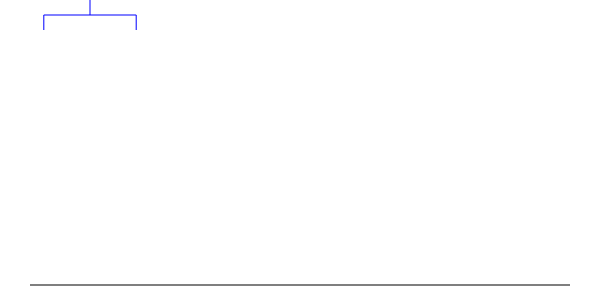

In [3]:
bfs = planning.BreadthFirstSearch(problem, verbose=1, timeout=None, node_bound=None)
status = bfs()
if status == planning.search.FOUND:
    plan = bfs.plan()
    state_sequence = bfs.state_sequence()
    print("#Generated nodes: " + str(bfs.info()["generated"]))
    if True: #len(plan) < 10:
        print("Plan:\n  " + "\n  ".join([str(op) for op in bfs.plan()]))
        for i, state in enumerate(bfs.state_sequence()):
            print("step " + str(i))
            display(state)

Let us apply IDS now:

[0.000s] Plan found with 0 action(s)
Plan:
  
step 0


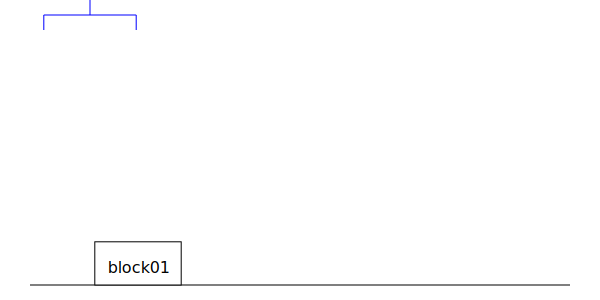

In [5]:
ids = planning.IterativeDeepeningSearch(problem, verbose=1, timeout=30.0)
status = ids()
if status == planning.search.FOUND:
    plan = ids.plan()
    state_sequence = ids.state_sequence()
    if len(plan) < 10:
        print("Plan:\n  " + "\n  ".join([str(op) for op in ids.plan()]))
        for i, state in enumerate(ids.state_sequence()):
            print("step " + str(i))
            display(state)

Now, let us apply heuristic search. We have implemented a generic Best First Search algorithm that accepts any heuristic and uses it to guide the search. We have implemented the following heuristics:
- Goal counting heuristic
- Relaxed goal counting heuristic
- Novelty-based heuristics
- Additive heuristic ($ h_{add} $)
- Relaxed planning graph heuristic (equivalent to $ h_{max} $)

We can combine these heuristics to achieve certain behaviour. For instance, we can use a linear combination of the accumulated cost and the novelty or additive heuristic to get the $\epsilon-A*$ (epsilon A-star) behaviour. The improvement with respect to the blind search is evident:

In [6]:
g = planning.heuristics.AccumulatedCost()
hadd = planning.heuristics.AdditiveHeuristic()
rpg = planning.heuristics.RelaxedPlanningGraphHeuristic()
hlinear = planning.heuristics.LinearCombination([g, hadd], (1, 5)) # 5 A-star with additive heuristic
h = planning.heuristics.ConcatenateHeuristic([hlinear, hadd])

bfs = planning.BestFirstSearch(problem, verbose=1, timeout=300.0, node_bound=20000,
                               heuristic=h, close_forever=False)
bfs()
plan = bfs.plan()
state_sequence = bfs.state_sequence()
print("#Generated nodes: " + str(bfs.info()["generated"]))
if len(plan) < 15:
    print("Plan:\n  " + "\n  ".join([str(op) for op in bfs.plan()]))
    for i, state in enumerate(bfs.state_sequence()):
        print("step " + str(i))
        display(state)

[0.001s] Plan found with 0 action(s)


KeyError: 'generated'

In [8]:
import random
import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)

h0_3 = []
h1_3 = []
h2_3 = []
h3_3 = []

N = 1000

generated = set()

for _ in tqdm.tqdm(range(N)):
    while True:
        n = random.randint(3, 4)
#         m = random.randint(3, 4)
        problem = domain.generate_problem(n, 3)
        if (problem.init(), problem.goal()) not in generated:
            generated.add((problem.init(), problem.goal()))
            break
    bfs = planning.BreadthFirstSearch(problem, verbose=0, timeout=5.0, node_bound=None)
    status = bfs()
    if status == planning.search.FOUND:
        h0_3.append(len(bfs.plan()))
        h1_3.append(hadd.h(problem.init(), problem.goal()))
        if h1_3[-1] == 0 and h0_3[-1] != 0:
            print(problem.trivial())
        h2_3.append(rpg.h(problem.init(), problem.goal()))
        h3_3.append(len(problem.goal().difference(problem.init())))


100%|██████████| 1000/1000 [00:15<00:00, 66.67it/s]


1000
1000


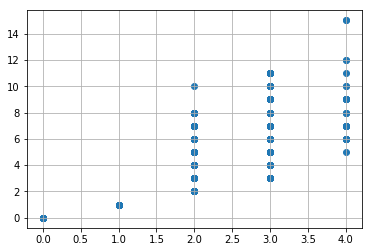

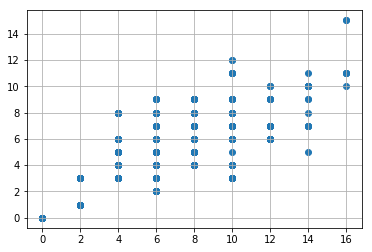

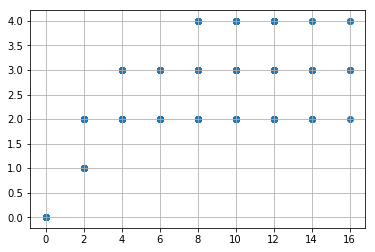

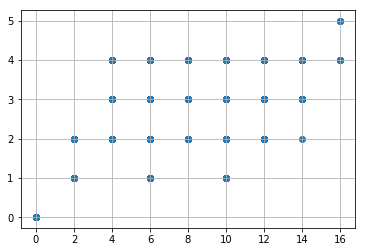

In [9]:
print(len(h0_3))
print(len(generated))

plt.scatter(h2_3, h1_3)
plt.grid("on")
plt.show()

plt.scatter(h0_3, h1_3)
plt.grid("on")
plt.show()

plt.scatter(h0_3, h2_3)
plt.grid("on")
plt.show()

plt.scatter(h0_3, h3_3)
plt.grid("on")
plt.show()

In [16]:
# Good for approximating the optimal heuristic... not so good for ranking

import numpy as np
from scipy.spatial import KDTree

random

X = np.array(list(zip(h1_3, h2_3, h3_3)))
y = np.array(h0_3)

n = X.shape[0]

p_split = 0.8

X_train = X[:int(p_split*n),:]
y_train = y[:int(p_split*n)]

X_test = X[int(p_split*n):,:]
y_test = y[int(p_split*n):]

xy_map = {}
for x, y in zip(X_train, y_train):
    try:
        xy_map[tuple(x)].append(y)
    except KeyError:
        xy_map[tuple(x)] = [y]
        
tree = KDTree(X_train)

error_abs_1 = 0
error_abs_2 = 0
error_abs_3 = 0

y_guess = []

for x,y in zip(X_test, y_test):
    _, nearest_i = tree.query(x)
    nearest = tuple(tree.data[nearest_i,:])
    guess = np.mean(xy_map[nearest])
    y_guess.append(guess)
#     print("{}, {}, {}".format(x,y,guess))
    error_abs_1 += abs(y-guess)
    error_abs_2 += abs(y-x[0])
    error_abs_3 += abs(y-x[1])
error_abs_1 /= X_test.shape[0]
error_abs_2 /= X_test.shape[0]
error_abs_3 /= X_test.shape[0]

ranking_errors_1 = 0

for diff1, diff2 in tqdm.tqdm_notebook([(y1-y1_, y2-y2_) for y1,y2 in zip(y_test, y_guess)
                                                         for y1_,y2_ in zip(y_test, y_guess)]):
    if diff1*diff2 < 0 or ((diff1 == 0) ^ (diff2 == 0)):
        ranking_errors_1 += 1
            
ranking_errors_2 = 0

for diff1, diff2 in tqdm.tqdm_notebook([(x[0]-x_[0], y-y_) for x,y in zip(X_test, y_test)
                                                           for x_,y_ in zip(X_test, y_test)]):
    if diff1*diff2 < 0 or ((diff1 == 0) ^ (diff2 == 0)):
        ranking_errors_2 += 1

print(error_abs_1)
print(error_abs_2)
print(error_abs_3)
              
print(ranking_errors_1)
print(ranking_errors_2)

HBox(children=(IntProgress(value=0, max=21316), HTML(value='')))

HBox(children=(IntProgress(value=0, max=21316), HTML(value='')))


1.6013107602249421
2.835616438356164
6.109589041095891
5332
6838
